## Workloads with Dask Delayed

In [1]:
from dask.distributed import Client, progress
client = Client(threads_per_worker=4, n_workers=1)
client

Client Scheduler: tcp://127.0.0.1:63553 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 4 Memory: 8.57 GB


In [2]:
import time
import random

def inc(x):
    time.sleep(random.random())
    return x + 1

def dec(x):
    time.sleep(random.random())
    return x - 1

def add(x, y):
    time.sleep(random.random())
    return x + y

In [3]:
%%time
x = inc(1)
y = dec(2)
z = add(x, y)
z

Wall time: 1.52 s


In [4]:
import dask
inc = dask.delayed(inc)
dec = dask.delayed(dec)
add = dask.delayed(add)

In [5]:
%%time
x = inc(1)
y = dec(2)
z = add(x, y)
z

Wall time: 0 ns


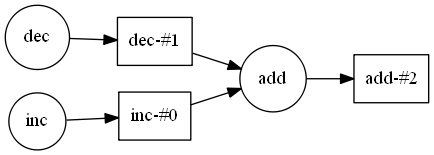

In [6]:
z.visualize(rankdir='LR')

In [7]:
z.compute()

3

In [9]:
%%time
zs = []
for i in range(256):
    x = inc(i)
    y = dec(x)
    z = add(x, y)
    zs.append(z)

zs = dask.persist(*zs)  # trigger computation in the background

Wall time: 102 ms


In [8]:
for i in range(10):
    client.cluster.start_worker(ncores=4)

In [10]:
L = zs
while len(L) > 1:
    new_L = []
    for i in range(0, len(L), 2):
        lazy = add(L[i], L[i + 1])  # add neighbors
        new_L.append(lazy)
    L = new_L                       # swap old list for new

dask.compute(L)

([65536],)

## Workloads with Futures

In [11]:
def inc(x):
    time.sleep(random.random())
    return x + 1

def dec(x):
    time.sleep(random.random())
    return x - 1

def add(x, y):
    time.sleep(random.random())
    return x + y

In [12]:
inc(1)

2

In [14]:
future = client.submit(inc, 1)  # returns immediately with pending future
future

<Future: status: pending, key: inc-52f5ba901b4d64f35fb452227f26c16e>

In [15]:
future

<Future: status: finished, type: int, key: inc-52f5ba901b4d64f35fb452227f26c16e>

In [16]:
future.result()

2

### Chain dependencies

You can submit tasks on other futures. This will create a dependency between the inputs and outputs. Dask will track the execution of all tasks, ensuring that downstream tasks are run at the proper time and place and with the proper data.

In [17]:
def inc(x):
    time.sleep(random.random())
    return x + 1

def double(x):
    time.sleep(random.random())
    return 2 * x

def add(x, y):
    time.sleep(random.random())
    return x + y

In [18]:
x = client.submit(inc, 1)
y = client.submit(double, 2)
z = client.submit(add, x, y)
z

<Future: status: pending, key: add-d4cd435899b855bd9329c287ef927dff>

In [19]:
z.result()

6

In [20]:
%%time
zs = []
for i in range(256):
    x = client.submit(inc, i)     # x = inc(i)
    y = client.submit(double, x)  # y = inc(x)
    z = client.submit(add, x, y)  # z = inc(y)
    zs.append(z)

total = client.submit(sum, zs)

Wall time: 544 ms


### Custom computation: Tree summation

In [21]:
L = zs
while len(L) > 1:
    new_L = []
    for i in range(0, len(L), 2):
        future = client.submit(add, L[i], L[i + 1])  # add neighbors
        new_L.append(future)
    L = new_L                                   # swap old list for new

### Building a computation dynamically

In [22]:
del future, L, new_L, total  # clear out some old work

In [23]:
from dask.distributed import as_completed

zs = client.map(inc, zs)
seq = as_completed(zs)

while seq.count() > 2:  # at least two futures left
    a = next(seq)
    b = next(seq)
    new = client.submit(add, a, b)  # add them together
    seq.add(new)                    # add new future back into loop

# Parallel

In [24]:
from dask.distributed import Client, progress
client = Client(threads_per_worker=4, n_workers=1)
client

C:\Users\Alejandro.Ortiz\AppData\Local\Continuum\miniconda3\lib\site-packages\distributed\bokeh\core.py:56: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


Client Scheduler: tcp://127.0.0.1:63773 Dashboard: http://127.0.0.1:63776/status,Cluster Workers: 1 Cores: 4 Memory: 8.57 GB


In [25]:
import time
import random

def costly_simulation(list_param):
    time.sleep(random.random())
    return sum(list_param)

In [26]:
%time costly_simulation([1, 2, 3, 4])

Wall time: 251 ms


10

In [27]:
import pandas as pd
import numpy as np

input_params = pd.DataFrame(np.random.random(size=(500, 4)),
                            columns=['param_a', 'param_b', 'param_c', 'param_d'])
input_params.head()

,param_a,param_b,param_c,param_d
0,0.037872,0.432324,0.850702,0.637560
1,0.263788,0.352271,0.631517,0.095520
2,0.390484,0.406217,0.135439,0.275807
3,0.027789,0.475971,0.158758,0.593302
4,0.282328,0.349730,0.915493,0.807858


In [28]:
%%time
results = []
for parameters in input_params.values[:10]:
    result = costly_simulation(parameters)
    results.append(result)

Wall time: 3.07 s


In [30]:
results

[1.9584571595746474,
 1.343096673904968,
 1.2079462686967897,
 1.2558202155932299,
 2.355408773065508,
 0.701380779708711,
 2.0763108520732407,
 2.0020722746431403,
 2.403658247142449,
 3.6646345331847687]

### Dask Delayed

In [31]:
%%time
import dask
lazy_results = []

for parameters in input_params.values[:10]:
    lazy_result = dask.delayed(costly_simulation)(parameters)
    lazy_results.append(lazy_result)

Wall time: 999 µs


In [32]:
lazy_results[0]

Delayed('costly_simulation-f1feb1b5-e9fe-4e96-b10f-31ef20885e5f')

## Run in parallel

The lazy_results list contains information about ten calls to costly_simulation that have not yet been run. Call .compute() when you want your result as normal Python objects.

If you started Client() above then you may want to watch the status page during computation.

In [33]:
%time dask.compute(*lazy_results)

Wall time: 1.88 s


(1.9584571595746474,
 1.343096673904968,
 1.2079462686967897,
 1.2558202155932299,
 2.355408773065508,
 0.701380779708711,
 2.0763108520732407,
 2.0020722746431403,
 2.403658247142449,
 3.6646345331847687)

In [34]:
import dask
lazy_results = []

for parameters in input_params.values:
    lazy_result = dask.delayed(costly_simulation)(parameters)
    lazy_results.append(lazy_result)

futures = dask.persist(*lazy_results)  # trigger computation in the background

In [35]:
for i in range(10):
    client.cluster.start_worker(ncores=4)

In [36]:
results = dask.compute(*futures)
results[:5]

(1.9584571595746474,
 1.343096673904968,
 1.2079462686967897,
 1.2558202155932299,
 2.355408773065508)

### Doing some analysis on the results

In [37]:
output = input_params.copy()
output['result'] = pd.Series(results, index=output.index)
output.sample(5)

,param_a,param_b,param_c,param_d,result
298,0.369889,0.829573,0.889677,0.766460,2.855599
123,0.242906,0.058397,0.606920,0.535603,1.443826
150,0.582510,0.150627,0.011825,0.363124,1.108085
217,0.714591,0.143219,0.190969,0.627981,1.676760
397,0.069554,0.688623,0.177958,0.330781,1.266917


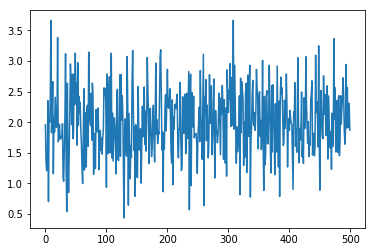

In [38]:
%matplotlib inline
output['result'].plot()

In [39]:
output['result'].mean()

1.9967750474851802

In [40]:
filtered_output = output[output['result'] > 2]
print(len(filtered_output))
# filtered_output.to_csv('/tmp/simulation_result.csv')

239


### Handling very large computation with bags

In [41]:
import dask.bag as db
b = db.from_sequence(list(input_params.values), npartitions=100)
b = b.map(costly_simulation)

In [42]:
%time results_bag = b.compute()

Wall time: 8.21 s


In [43]:
np.all(results) == np.all(results_bag)

True